In [2]:
# !pip install tensorflow
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import random
import keras
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
jan_df =  pd.read_parquet('/Users/Mihir/Downloads/yellow_tripdata_2020-01.parquet', engine='fastparquet')
jan_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,N,238,239,1,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5,NaN
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,N,239,238,1,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5,NaN
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,N,238,238,1,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5,NaN
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,N,238,151,1,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0,NaN
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.00,1.0,N,193,193,2,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,2,2020-01-31 23:08:00,2020-01-31 23:34:00,NaN,12.07,NaN,None,191,35,0,52.18,2.75,0.5,0.00,0.00,0.3,55.73,NaN,NaN
6405004,2,2020-01-31 23:00:00,2020-01-31 23:44:00,NaN,23.48,NaN,None,186,117,0,54.01,2.75,0.5,0.00,6.12,0.3,63.68,NaN,NaN
6405005,2,2020-01-31 23:13:00,2020-01-31 23:38:00,NaN,12.09,NaN,None,164,131,0,38.02,2.75,0.5,0.00,6.12,0.3,47.69,NaN,NaN
6405006,2,2020-01-31 23:02:54,2020-01-31 23:27:10,NaN,11.65,NaN,None,10,16,0,28.74,2.75,0.0,0.00,0.00,0.3,31.79,NaN,NaN


In [4]:
jan_df = jan_df.drop('airport_fee', axis = 1)

In [5]:
# creating target variable named as trip_duration
jan_df['trip_duration'] = jan_df['tpep_dropoff_datetime'] - jan_df['tpep_pickup_datetime']
jan_df['trip_duration'] = jan_df['trip_duration'] / np.timedelta64(1, 'm')

In [6]:
# pickup from day, month, date, hour, min, weekday
jan_df['pickup_day'] = jan_df['tpep_pickup_datetime'].dt.day
jan_df['pickup_month'] = jan_df['tpep_pickup_datetime'].dt.month
jan_df['date'] = jan_df['tpep_pickup_datetime'].dt.dayofyear
jan_df['pickup_hour'] = jan_df['tpep_pickup_datetime'].dt.hour
jan_df['pickup_min'] = jan_df['tpep_pickup_datetime'].dt.minute
jan_df['pickup_weekday'] = jan_df['tpep_pickup_datetime'].dt.weekday
jan_df['dropoff_weekday'] = jan_df['tpep_dropoff_datetime'].dt.weekday

#creating new column of drop off in minute as it will easy to read the data.
jan_df['dropoff_min'] = jan_df['tpep_dropoff_datetime'].dt.minute

In [7]:
weather = pd.read_csv('/Users/Mihir/Downloads/export.csv')
# weather

In [8]:
import datetime
weather['date'] = pd.to_datetime(weather.date,format = '%Y-%m-%d')
weather['date'] = weather.date.dt.dayofyear
weather = weather.drop(['tmin','tmax','prcp','snow','wdir','wspd','wpgt','pres','tsun'],axis = 1)

In [9]:
nyc_weather = pd.merge(jan_df, weather, on = 'date')

In [10]:
nyc_weather = nyc_weather.drop(['store_and_fwd_flag','tpep_pickup_datetime','tpep_dropoff_datetime','VendorID','passenger_count','RatecodeID','PULocationID','DOLocationID','payment_type','mta_tax','tip_amount','pickup_month'],axis = 1)

In [11]:
nyc_weather = nyc_weather.drop(['tolls_amount','improvement_surcharge','congestion_surcharge'], axis =1)

In [12]:
nyc_weather = nyc_weather.fillna(0)

In [13]:
nyc_weather.drop(['pickup_day'],axis =1)

,trip_distance,fare_amount,extra,total_amount,trip_duration,date,pickup_hour,pickup_min,pickup_weekday,dropoff_weekday,dropoff_min,tavg
0,1.20,6.00,3.00,11.27,4.800000,1,0,28,2,2,33,3.6
1,1.20,7.00,3.00,12.30,7.416667,1,0,35,2,2,43,3.6
2,0.60,6.00,3.00,10.80,6.183333,1,0,47,2,2,53,3.6
3,0.80,5.50,0.50,8.16,4.850000,1,0,55,2,2,0,3.6
4,0.00,3.50,0.50,4.80,2.300000,1,0,1,2,2,4,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
6404814,12.07,52.18,2.75,55.73,26.000000,31,23,8,4,4,34,4.3
6404815,23.48,54.01,2.75,63.68,44.000000,31,23,0,4,4,44,4.3
6404816,12.09,38.02,2.75,47.69,25.000000,31,23,13,4,4,38,4.3
6404817,11.65,28.74,2.75,31.79,24.266667,31,23,2,4,4,27,4.3


In [14]:
nyc_weather = nyc_weather.drop(['fare_amount','extra','total_amount','pickup_hour','pickup_min','pickup_weekday','dropoff_weekday','dropoff_min'],axis = 1)

In [15]:
x =  nyc_weather.drop("trip_duration", axis=1)
y = nyc_weather["trip_duration"]

In [16]:
x = np.array(x)
y = np.array(y)

In [17]:
scaled_df = MinMaxScaler().fit_transform(x)
scaled_df = pd.DataFrame(scaled_df)
num_features = scaled_df.shape[1]

In [46]:
# x_train = nyc_weather.head(5123855).drop("trip_duration",axis = 1)
# x_test = nyc_weather.head(5123855).drop("trip_distance","fare_amount","extra","total_amount","trip_duration","pickup_day","date","pickup_hour","pickup_min","pickup_weekday","dropoff_weekday","dropoff_min","tavg",)

In [47]:
# y_train = nyc_weather.head(1280964)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 18)
print(x_train.shape)
print(x_test.shape)

(5123855, 4)
(1280964, 4)


## Model1 - Sequential

In [19]:
model1 = Sequential()
model1.add(Dense(128, input_dim=num_features, activation='relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(10, activation = 'relu'))
model1.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse', 'mae', 'mape'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 11,306
Trainable params: 11,306
Non-trainable params: 0
_________________________________________________________________


In [20]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss='mae', 
    metrics=['mse', 'mae', 'mape','accuracy']
    )

history = model1.fit(
    x_train,
    y_train,
    batch_size = 256,
    epochs=50,
    validation_data=(x_test, y_test), 
    shuffle=True,
    verbose=True,
)

Epoch 1/50
20016/20016 [==============================] - 62s 3ms/step - loss: 8.1982 - mse: 17324.5742 - mae: 8.1982 - mape: 4560219.5000 - accuracy: 9.1572e-04 - val_loss: 9.7050 - val_mse: 4075.2756 - val_mae: 9.7050 - val_mape: 7263370.0000 - val_accuracy: 1.4833e-04
Epoch 2/50
20016/20016 [==============================] - 59s 3ms/step - loss: 9.6779 - mse: 4007.6628 - mae: 9.6779 - mape: 7201521.5000 - accuracy: 8.8000e-04 - val_loss: 9.7047 - val_mse: 4075.5479 - val_mae: 9.7047 - val_mape: 7245780.5000 - val_accuracy: 7.2524e-04
Epoch 3/50
20016/20016 [==============================] - 59s 3ms/step - loss: 9.6780 - mse: 4007.6521 - mae: 9.6780 - mape: 7201395.5000 - accuracy: 9.0732e-04 - val_loss: 9.7127 - val_mse: 4072.3601 - val_mae: 9.7127 - val_mape: 7454083.5000 - val_accuracy: 7.2524e-04
Epoch 4/50
20016/20016 [==============================] - 60s 3ms/step - loss: 9.6780 - mse: 4007.6829 - mae: 9.6780 - mape: 7200542.0000 - accuracy: 8.9366e-04 - val_loss: 9.7117 - val_

In [21]:
df_model = pd.DataFrame(history.history)

In [22]:
df_model

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy
0,8.198216,17324.574219,8.198216,4560219.5,0.000916,9.705027,4075.275635,9.705027,7263370.0,0.000148
1,9.677876,4007.662842,9.677876,7201521.5,0.000880,9.704731,4075.547852,9.704731,7245780.5,0.000725
2,9.678020,4007.652100,9.678020,7201395.5,0.000907,9.712741,4072.360107,9.712741,7454083.5,0.000725
3,9.678007,4007.682861,9.678007,7200542.0,0.000894,9.711737,4072.605957,9.711737,7437539.0,0.001145
4,9.677893,4007.657227,9.677893,7202985.5,0.000872,9.708342,4073.632324,9.708342,7369745.0,0.001087
5,9.677963,4007.665771,9.677963,7199793.0,0.000888,9.705078,4078.035156,9.705078,7090866.0,0.000347
6,9.678018,4007.642090,9.678018,7200505.0,0.000891,9.707437,4073.975098,9.707437,7347210.0,0.000725
7,9.677965,4007.668457,9.677965,7199565.5,0.000942,9.708082,4079.648682,9.708082,6993755.5,0.001087
8,9.677995,4007.671387,9.677995,7199006.0,0.000818,9.710546,4072.934570,9.710546,7415812.5,0.000979
9,9.677974,4007.655762,9.677974,7202829.0,0.000820,9.705902,4078.597900,9.705902,7056738.5,0.000347


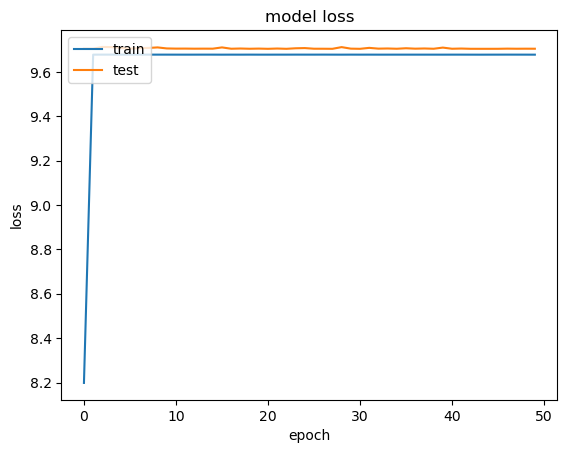

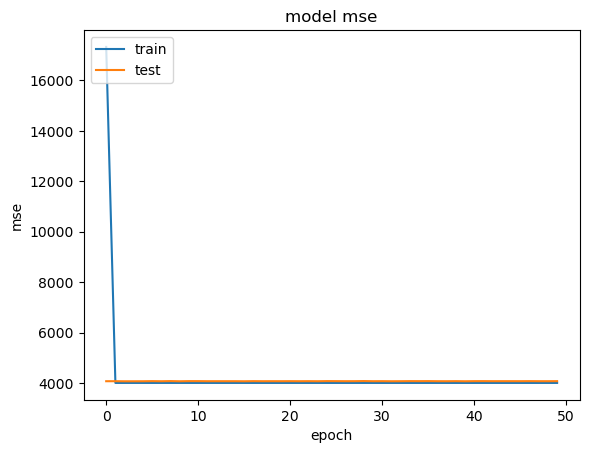

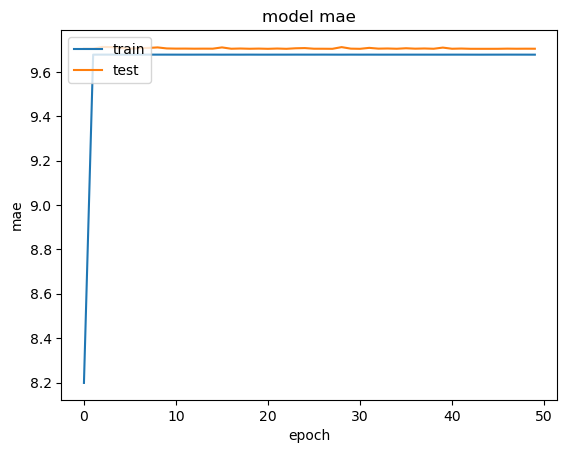

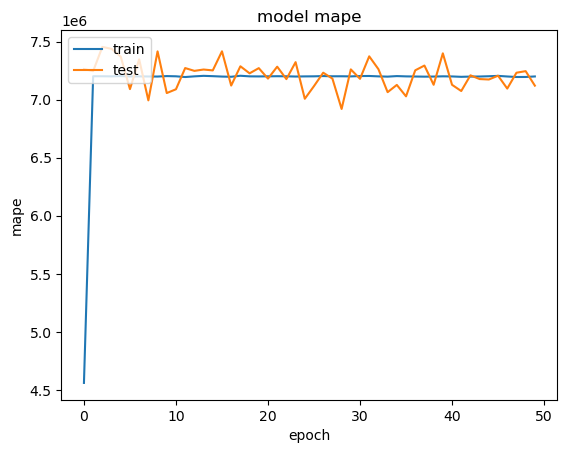

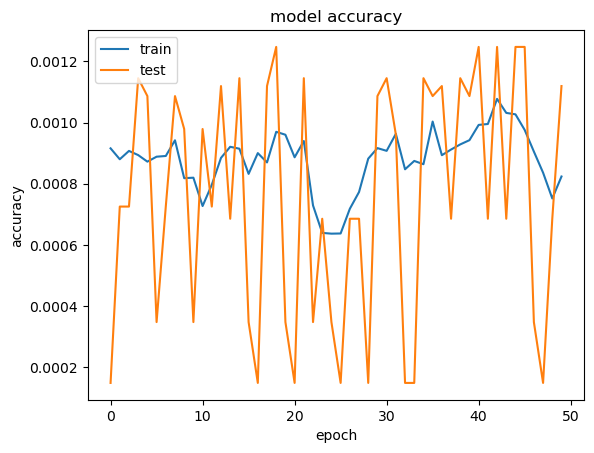

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model2 - DNN

In [24]:
input_a = tf. keras.layers.Input(shape = (x.shape[1]), name = 'InputLayer')
hidden1 = tf.keras.layers.Dense(100, activation = 'relu', name= 'HiddenLayer1')(input_a)
hidden2 = tf.keras.layers.Dense(50, activation = 'relu',name='HiddenLayer2')(hidden1)
output = tf.keras.layers.Dense(1, name = 'output')(hidden2)

In [25]:
model2 = tf.keras.Model(inputs = [input_a], outputs = [output])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 4)]               0         
                                                                 
 HiddenLayer1 (Dense)        (None, 100)               500       
                                                                 
 HiddenLayer2 (Dense)        (None, 50)                5050      
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [26]:
#DNN model is my choice as it having a constant loss of 6.3 so it will be more accurate and we can run other data as well.
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss= 'mae', 
    metrics=['mse', 'mae', 'mape', 'accuracy']
)


history = model2.fit(
    x_train,
    y_train,
    batch_size = 256,
    epochs=50,
    validation_data=(x_test, y_test),
    shuffle=True, 
    verbose=True,
)

Epoch 1/50
20016/20016 [==============================] - 60s 3ms/step - loss: 6.4312 - mse: 17721.0039 - mae: 6.4312 - mape: 1383126.3750 - accuracy: 1.7487e-04 - val_loss: 6.7530 - val_mse: 3989.6045 - val_mae: 6.7530 - val_mape: 2363134.5000 - val_accuracy: 1.4833e-04
Epoch 2/50
20016/20016 [==============================] - 59s 3ms/step - loss: 6.3487 - mse: 3908.8940 - mae: 6.3487 - mape: 1389722.7500 - accuracy: 1.4891e-04 - val_loss: 6.3752 - val_mse: 3973.9343 - val_mae: 6.3752 - val_mape: 2000638.3750 - val_accuracy: 1.4833e-04
Epoch 3/50
20016/20016 [==============================] - 60s 3ms/step - loss: 6.3439 - mse: 3908.7917 - mae: 6.3439 - mape: 1335985.5000 - accuracy: 1.5106e-04 - val_loss: 6.5788 - val_mse: 3985.8191 - val_mae: 6.5788 - val_mape: 867910.8125 - val_accuracy: 1.4833e-04
Epoch 4/50
20016/20016 [==============================] - 56s 3ms/step - loss: 6.3459 - mse: 3908.8608 - mae: 6.3459 - mape: 1311191.1250 - accuracy: 1.5789e-04 - val_loss: 6.7400 - val_m

In [27]:
model2_df = pd.DataFrame(history.history)

In [28]:
model2_df

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy
0,6.431194,17721.003906,6.431194,1383126.375,0.000175,6.752985,3989.604492,6.752985,2.363134e+06,0.000148
1,6.348677,3908.894043,6.348677,1389722.750,0.000149,6.375173,3973.934326,6.375173,2.000638e+06,0.000148
2,6.343885,3908.791748,6.343885,1335985.500,0.000151,6.578820,3985.819092,6.578820,8.679108e+05,0.000148
3,6.345853,3908.860840,6.345853,1311191.125,0.000158,6.740005,3966.905273,6.740005,1.825876e+06,0.000148
4,6.347137,3909.021484,6.347137,1331139.125,0.000162,7.980380,3967.602295,7.980380,4.321066e+06,0.000148
5,6.420049,3917.187012,6.420049,1552807.000,0.000157,6.829279,4004.018555,6.829279,3.864724e+05,0.000590
6,6.345213,3919.183838,6.345213,1293456.000,0.000169,6.483046,3974.327148,6.483046,4.414248e+05,0.000758
7,6.341500,3908.654297,6.341500,1292658.750,0.000164,6.548260,3982.631348,6.548260,7.434913e+05,0.000148
8,6.342982,3908.675049,6.342982,1305834.250,0.000162,6.407234,3984.713379,6.407234,1.477592e+06,0.000148
9,6.345672,3908.733887,6.345672,1315896.750,0.000160,6.762409,3970.867920,6.762409,2.525716e+06,0.000148


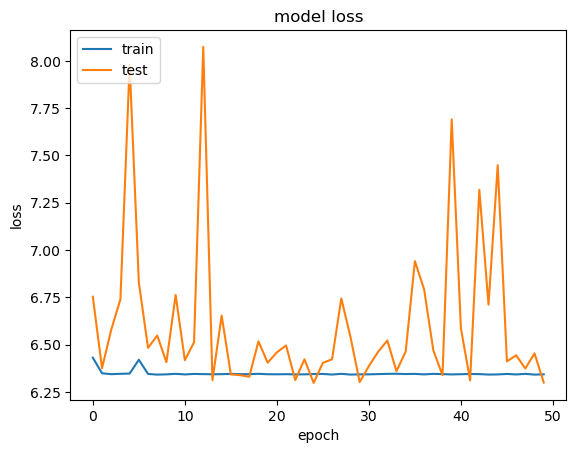

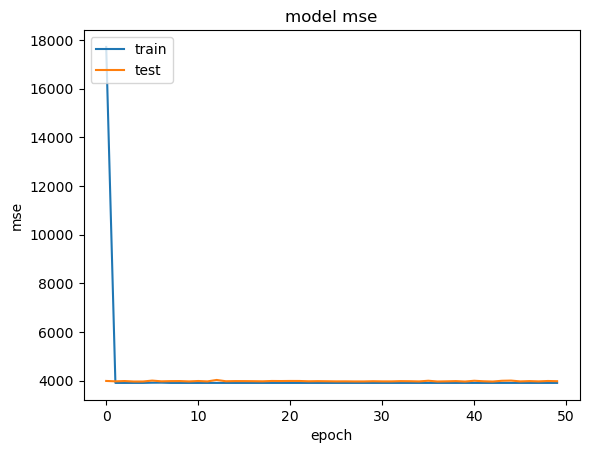

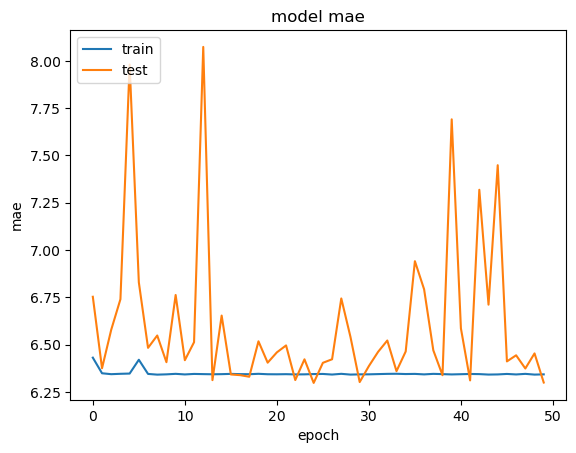

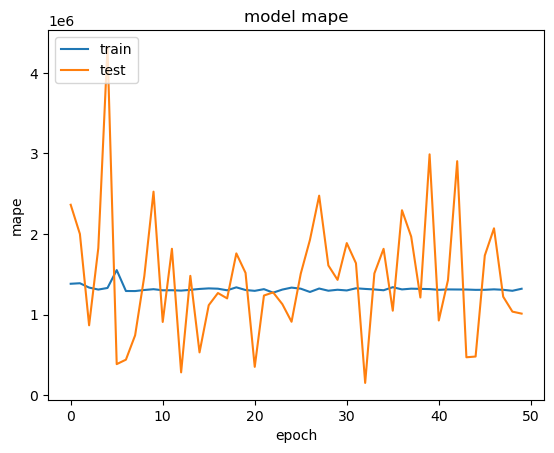

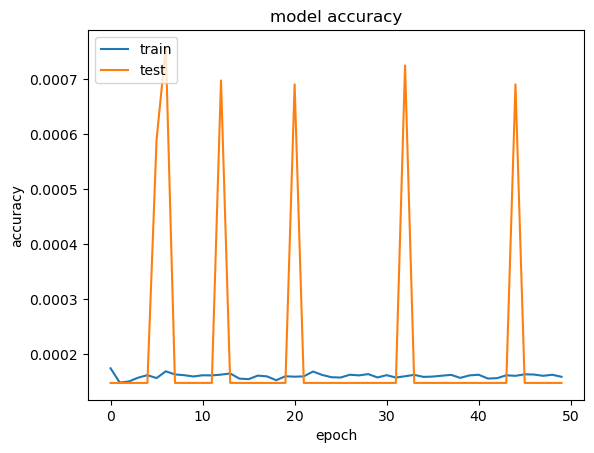

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Tensorboard

In [30]:
# !pip install tensorboard

In [43]:
from keras.callbacks import TensorBoard

In [33]:
tensorboard_callback = TensorBoard(
    log_dir='tbooards/logs/DNNAdam100Epoch',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss='mae', 
    metrics=['mse', 'mae', 'mape','accuracy']
    )

history = model1.fit(
    x_train,
    y_train,
    batch_size = 256,
    epochs=50,
    validation_data=(x_test, y_test), 
    shuffle=True,
    verbose=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
20016/20016 [==============================] - 61s 3ms/step - loss: 9.6780 - mse: 4007.6453 - mae: 9.6780 - mape: 7199321.5000 - accuracy: 7.8730e-04 - val_loss: 9.7043 - val_mse: 4076.0754 - val_mae: 9.7043 - val_mape: 7212414.0000 - val_accuracy: 0.0011
Epoch 2/50
20016/20016 [==============================] - 60s 3ms/step - loss: 9.6780 - mse: 4007.6614 - mae: 9.6780 - mape: 7201336.0000 - accuracy: 7.6036e-04 - val_loss: 9.7082 - val_mse: 4079.6956 - val_mae: 9.7082 - val_mape: 6990952.0000 - val_accuracy: 6.8542e-04
Epoch 3/50
20016/20016 [==============================] - 59s 3ms/step - loss: 9.6779 - mse: 4007.6921 - mae: 9.6779 - mape: 7200652.5000 - accuracy: 7.6076e-04 - val_loss: 9.7044 - val_mse: 4075.9143 - val_mae: 9.7044 - val_mape: 7222428.5000 - val_accuracy: 0.0011
Epoch 4/50
20016/20016 [==============================] - 62s 3ms/step - loss: 9.6780 - mse: 4007.6489 - mae: 9.6780 - mape: 7200251.5000 - accuracy: 7.6251e-04 - val_loss: 9.7043 - val_mse: 4077

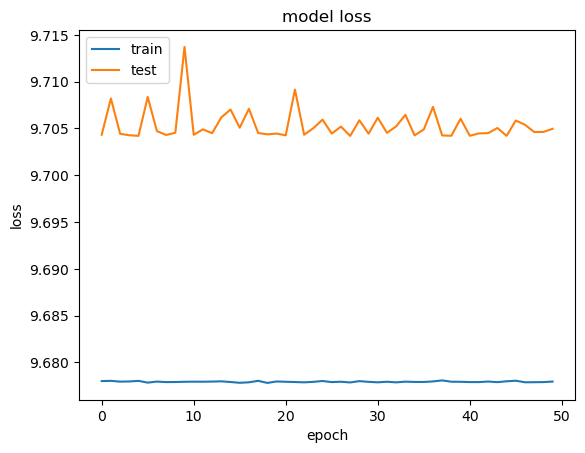

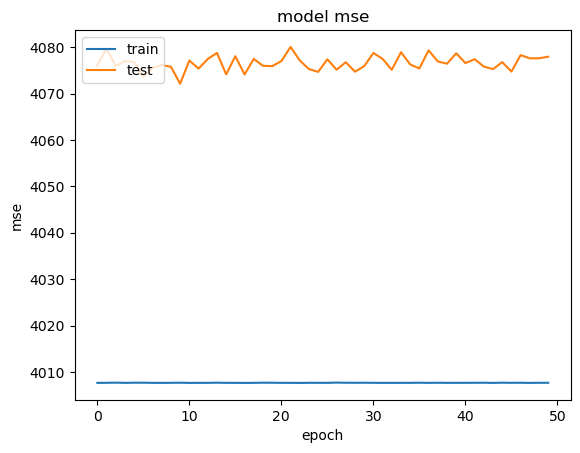

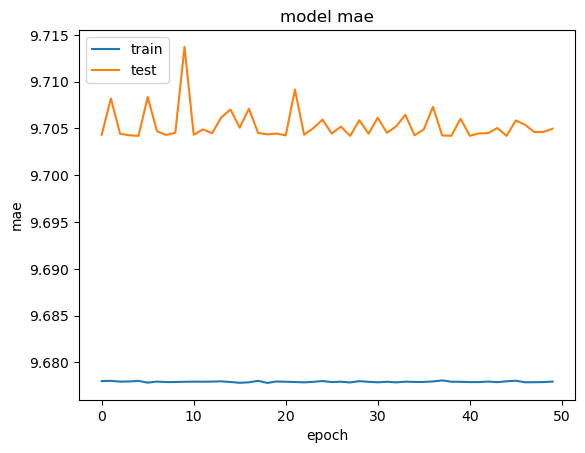

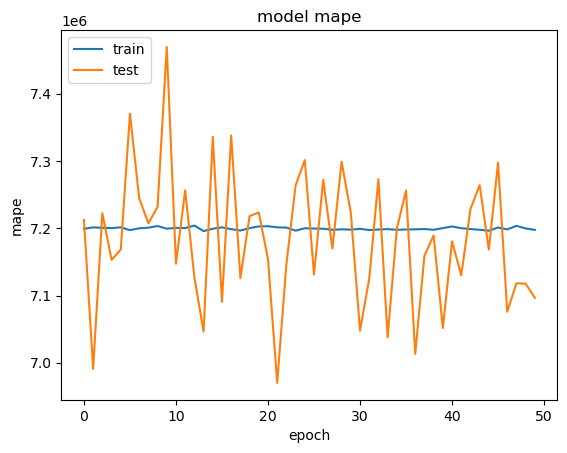

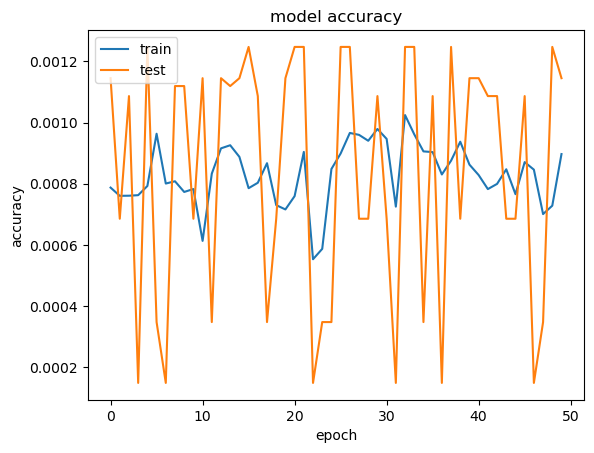

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model3 Multi Layer Percepton


In [35]:
from sklearn.neural_network import MLPRegressor

from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [36]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(150,100,50),
    max_iter = 5,
    activation = 'relu',
    solver = 'adam',
    random_state = 5,
    verbose = True
)

In [37]:
mlp_model.fit(
    x_train,
    y_train
)

Iteration 1, loss = 8977.33302603
Iteration 2, loss = 6640.79100520
Iteration 3, loss = 3670.68663068
Iteration 4, loss = 15885.34222997
Iteration 5, loss = 6327.03844064


/Users/Mihir/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=5, random_state=5,
             verbose=True)

In [41]:
model1.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 4),
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 64,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initial

In [49]:
model2.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'InputLayer'},
   'name': 'InputLayer',
   'inbound_nodes': []},
  {'class_name': 'Dense',
   'config': {'name': 'HiddenLayer1',
    'trainable': True,
    'dtype': 'float32',
    'units': 100,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'HiddenLayer1',
   'inbound_nodes': [[['InputLayer', 0, 0, {}]]]},
  {'class_name': 'Dense',
   'config': {'name': 'HiddenLayer2',
    'trainable': True,
    'dtype': 'float32',
    'units': 50,
    'activation': 'relu',
    'use_bias': True,
    'kernel

In [46]:
%load_ext tensorboard

In [48]:
# %load_ext tensorboard.notebook
%tensorboard --logdir /Users/Mihir/myprojects/tbooards/logs

# /Users/Mihir/myprojects/tbooards/logs

In [53]:
y_pred = model1.predict(x_test).flatten()

40031/40031 [==============================] - 46s 1ms/step
